In [1]:
import pandas as pd
import geopandas as gpd
from time import sleep
import datetime
import requests
from urllib.parse import quote
from bs4 import BeautifulSoup
import numpy as np
import random
import logging
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
namespaces = {
    'netex': 'http://www.netex.org.uk/netex'
}

df_stop = pd.read_xml(r"./data/netex_oebb_StoppPlaces_2023.xml",
                      xpath=".//netex:StopPlace", namespaces=namespaces)

df_stop.head()

,version,created,id,ValidBetween,keyList,Name,ShortName,Description,PrivateCode,Centroid,TransportMode,StopPlaceType,unlocalisedEquipments,quays,navigationPaths
0,any,2022-12-20T09:45:42.1137475+01:00,at-43-3852,NaN,NaN,Kapellerfeld,Gef H1,None,571,NaN,rail,railStation,NaN,NaN,NaN
1,any,2022-12-20T09:45:42.1822746+01:00,at-44-48790,NaN,NaN,Taufkirchen a d Pram,Tp,None,2236,NaN,rail,railStation,NaN,NaN,NaN
2,any,2022-12-20T09:45:42.148452+01:00,at-43-3101,NaN,NaN,Baden,Bf H1,None,149,NaN,rail,railStation,NaN,NaN,NaN
3,any,2022-12-20T09:45:42.1237794+01:00,at-49-532,NaN,NaN,Wien Hirschstetten,Stc,None,2096,NaN,rail,railStation,NaN,NaN,NaN
4,any,2022-12-20T09:45:42.1686293+01:00,at-43-4995,NaN,NaN,Traiskirchen Aspangbahn,Ti,Bestellung als Bedarfshalt iSd. § 121 EisbBBV ...,2218,NaN,rail,railStation,NaN,NaN,NaN


In [3]:
url = "https://v5.db.transport.rest/locations"
params = {
    'query': 'Wien'  # Example: Wien
}

# Make the GET request
response = requests.get(url, params=params)

# Check the response status
if response.status_code == 200:
    data = response.json()
else:
    print(f"Error: {response.status_code} - {response.text}")
    
pd.DataFrame(data)

,type,id,name,location,products,isMeta
0,stop,8196001,WIEN,"{'type': 'location', 'id': '8196001', 'latitud...","{'nationalExpress': True, 'national': True, 'r...",True
1,station,8103000,Wien Hbf,"{'type': 'location', 'id': '8103000', 'latitud...","{'nationalExpress': True, 'national': True, 'r...",NaN
2,station,8100514,Wien Meidling,"{'type': 'location', 'id': '8100514', 'latitud...","{'nationalExpress': True, 'national': True, 'r...",NaN
3,stop,8100353,Wien Airport,"{'type': 'location', 'id': '8100353', 'latitud...","{'nationalExpress': True, 'national': True, 'r...",NaN
4,station,8100003,Wien Westbahnhof,"{'type': 'location', 'id': '8100003', 'latitud...","{'nationalExpress': False, 'national': False, ...",NaN


# Extract data from HAFAS

`2024-10-10T15:30:45`

**Note:** HAFAS does not store delays for trains not in transit and the limit for a given result is 170 stations.

https://v6.db.transport.rest/api.html

## Arrivals

... Vienna only to start 

In [16]:
# Create df_arrivals dataframe
stop_id = []
stop_name = []
origin_id = []
origin_name = []
line_id = []
fahrtNr = []
line_name = []
provenance = []
planned_when = []
when = []
delay=[]
trips_arrivals = [] 


    # Add For loop of different times throughout the year
    
stops = [8103000, # Vienna
         8100108, # Innsbruck
         8100013, # Linz
         8100002, # Salzburg
         8100147, # Villach
         8100085, # Klagenfurt
         8100173, # Graz
         8100090  # Bregenz
        ] 

# Different times throughout the year
times = [
    "2024-02-28T12:42:43",
    "2024-04-24T11:16:21",
    "2024-01-26T04:12:19",
    "2024-05-28T16:37:48",
    "2024-05-16T15:58:18",
    "2024-03-28T20:29:59",
    "2024-08-05T11:41:00",
    "2024-06-15T02:48:35",
    "2024-09-20T14:21:15",
    "2024-11-06T11:21:01"
]

for i in range(0, len(stops)):
    stop = stops[i]
    sleep(2)
    
    for j in range(0, len(times)):
        url = f"https://v6.db.transport.rest/stops/{stop}/arrivals"
        params = {
            'when': times[j], 
            'duration': 10080, 
            'results': 500,
            # 'regionalExp': 'false',
            'regional': 'false',
            'suburban': 'false',
            'bus': 'false',
            'subway': 'false',
            'tram': 'false',
            'taxi': 'false'
        }

        response = requests.get(url, params=params)

        if response.status_code == 200:
            data_3 = response.json()
        else:
            print(f"Error: {response.status_code}")

        for k in range(0, pd.DataFrame(data_3["arrivals"]).shape[0]):
            stop_id.append(data_3["arrivals"][k]["stop"]["id"])
            stop_name.append(data_3["arrivals"][k]["stop"]["name"])
            origin_id.append(data_3["arrivals"][k]["origin"]["id"])
            origin_name.append(data_3["arrivals"][k]["origin"]["name"])
            line_id.append(data_3["arrivals"][k]["line"]["id"])
            fahrtNr.append(data_3["arrivals"][k]["line"]["fahrtNr"])
            line_name.append(data_3["arrivals"][k]["line"]["name"])
            provenance.append(data_3["arrivals"][k]["provenance"])
            planned_when.append(data_3["arrivals"][k]["plannedWhen"])
            when.append(data_3["arrivals"][k]["when"])
            delay.append(data_3["arrivals"][k]["delay"])
            trips_arrivals.append(data_3["arrivals"][k]["tripId"])
    
df_arrivals = pd.DataFrame({"stop_id": stop_id,
                            "stop_name": stop_name,
                            "origin_id": origin_id,
                            "origin_name": origin_name,
                            "line_id": line_id,
                            # "fahrtNr": fahrtNr,
                            "line_name": line_name,
                            "provenance": provenance,
                            "planned_when": planned_when,
                            "when": when,
                            "delay": delay,
                            "trip_id":trips_arrivals})

#df_arrivals["date"] = pd.to_datetime(df_arrivals['planned_when'], errors='coerce').dt.date
#df_arrivals["planned_arrival"] = pd.to_datetime(df_arrivals['planned_when'], errors='coerce').dt.time
#df_arrivals["arrival"] = pd.to_datetime(df_arrivals['when'], errors='coerce').dt.time
#df_arrivals = df_arrivals.drop(["planned_when", "when"], axis=1)

df_arrivals

Error: 503
Error: 503
Error: 503
Error: 503
Error: 503
Error: 503
Error: 503
Error: 503
Error: 503
Error: 503
Error: 502


,stop_id,stop_name,origin_id,origin_name,line_id,line_name,provenance,planned_when,when,delay,trip_id
0,8100090,Bregenz,8003693,Lindau-Reutin,ec-194,EC 194,München Hbf Gl.27-36,2024-11-06T12:58:00+01:00,2024-11-06T12:58:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#484518#TA#0#DA#6...
1,8100090,Bregenz,8506314,St. Margrethen SG,ec-191,EC 191,Zürich HB,2024-11-06T13:00:00+01:00,2024-11-06T13:00:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#484490#TA#0#DA#6...
2,8100090,Bregenz,8100122,Dornbirn,rjx-660,RJX 660,Wien Hbf,2024-11-06T13:17:00+01:00,2024-11-06T13:17:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#680149#TA#0#DA#6...
3,8100090,Bregenz,8003693,Lindau-Reutin,ec-192,EC 192,München Hbf Gl.27-36,2024-11-06T14:58:00+01:00,2024-11-06T14:58:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#484498#TA#0#DA#6...
4,8100090,Bregenz,8506314,St. Margrethen SG,ec-193,EC 193,Zürich HB,2024-11-06T15:00:00+01:00,2024-11-06T15:00:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#484510#TA#0#DA#6...
...,...,...,...,...,...,...,...,...,...,...,...
6510,8100090,Bregenz,8003693,Lindau-Reutin,rjx-897,RJX 897,Stuttgart Hbf,2024-11-07T10:38:00+01:00,2024-11-07T10:38:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#499543#TA#0#DA#7...
6511,8100090,Bregenz,8003693,Lindau-Reutin,ec-196,EC 196,München Hbf Gl.27-36,2024-11-07T10:58:00+01:00,2024-11-07T10:58:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#484542#TA#0#DA#7...
6512,8100090,Bregenz,8506314,St. Margrethen SG,ec-99,EC 99,Zürich HB,2024-11-07T11:00:00+01:00,2024-11-07T11:00:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#501611#TA#0#DA#7...
6513,8100090,Bregenz,8100122,Dornbirn,rj-668,RJ 668,Linz Hbf,2024-11-07T11:17:00+01:00,2024-11-07T11:17:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#680204#TA#0#DA#7...


In [17]:
df_arrivals_at = df_arrivals[df_arrivals["provenance"].isin(df_stop["Name"])]
df_arrivals_at

,stop_id,stop_name,origin_id,origin_name,line_id,line_name,provenance,planned_when,when,delay,trip_id
26,8100090,Bregenz,8100122,Dornbirn,rj-668,RJ 668,Linz Hbf,2024-11-07T11:17:00+01:00,2024-11-07T11:17:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#680204#TA#0#DA#7...
27,8100090,Bregenz,8100473,Bregenz Riedenburg,ice-118,ICE 118,Innsbruck Hbf,2024-11-07T11:49:00+01:00,2024-11-07T11:49:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#480977#TA#0#DA#7...
54,8100090,Bregenz,8100122,Dornbirn,rj-668,RJ 668,Linz Hbf,2024-11-07T11:17:00+01:00,2024-11-07T11:17:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#680204#TA#0#DA#7...
55,8100090,Bregenz,8100473,Bregenz Riedenburg,ice-118,ICE 118,Innsbruck Hbf,2024-11-07T11:49:00+01:00,2024-11-07T11:49:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#480977#TA#0#DA#7...
82,8100090,Bregenz,8100122,Dornbirn,rj-668,RJ 668,Linz Hbf,2024-11-07T11:17:00+01:00,2024-11-07T11:17:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#680204#TA#0#DA#7...
...,...,...,...,...,...,...,...,...,...,...,...
6478,8100090,Bregenz,8100122,Dornbirn,rj-668,RJ 668,Salzburg Hbf,2024-09-21T11:17:00+02:00,2024-09-21T11:17:00+02:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#680203#TA#0#DA#2...
6479,8100090,Bregenz,8100473,Bregenz Riedenburg,ice-118,ICE 118,Innsbruck Hbf,2024-09-21T11:49:00+02:00,2024-09-21T11:49:00+02:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#480972#TA#0#DA#2...
6485,8100090,Bregenz,8100122,Dornbirn,rjx-662,RJX 662,Flughafen Wien,2024-09-21T15:17:00+02:00,2024-09-21T15:17:00+02:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#680168#TA#0#DA#2...
6513,8100090,Bregenz,8100122,Dornbirn,rj-668,RJ 668,Linz Hbf,2024-11-07T11:17:00+01:00,2024-11-07T11:17:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#680204#TA#0#DA#7...


In [18]:
df_arrivals_int = df_arrivals[~df_arrivals["provenance"].isin(df_stop["Name"])]
df_arrivals_int

,stop_id,stop_name,origin_id,origin_name,line_id,line_name,provenance,planned_when,when,delay,trip_id
0,8100090,Bregenz,8003693,Lindau-Reutin,ec-194,EC 194,München Hbf Gl.27-36,2024-11-06T12:58:00+01:00,2024-11-06T12:58:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#484518#TA#0#DA#6...
1,8100090,Bregenz,8506314,St. Margrethen SG,ec-191,EC 191,Zürich HB,2024-11-06T13:00:00+01:00,2024-11-06T13:00:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#484490#TA#0#DA#6...
2,8100090,Bregenz,8100122,Dornbirn,rjx-660,RJX 660,Wien Hbf,2024-11-06T13:17:00+01:00,2024-11-06T13:17:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#680149#TA#0#DA#6...
3,8100090,Bregenz,8003693,Lindau-Reutin,ec-192,EC 192,München Hbf Gl.27-36,2024-11-06T14:58:00+01:00,2024-11-06T14:58:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#484498#TA#0#DA#6...
4,8100090,Bregenz,8506314,St. Margrethen SG,ec-193,EC 193,Zürich HB,2024-11-06T15:00:00+01:00,2024-11-06T15:00:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#484510#TA#0#DA#6...
...,...,...,...,...,...,...,...,...,...,...,...
6508,8100090,Bregenz,8003693,Lindau-Reutin,ec-198,EC 198,München Hbf Gl.27-36,2024-11-07T08:58:00+01:00,2024-11-07T08:58:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#484854#TA#0#DA#7...
6509,8100090,Bregenz,8506314,St. Margrethen SG,ec-97,EC 97,Zürich HB,2024-11-07T09:00:00+01:00,2024-11-07T09:00:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#501262#TA#0#DA#7...
6510,8100090,Bregenz,8003693,Lindau-Reutin,rjx-897,RJX 897,Stuttgart Hbf,2024-11-07T10:38:00+01:00,2024-11-07T10:38:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#499543#TA#0#DA#7...
6511,8100090,Bregenz,8003693,Lindau-Reutin,ec-196,EC 196,München Hbf Gl.27-36,2024-11-07T10:58:00+01:00,2024-11-07T10:58:00+01:00,None,2|#VN#1#ST#1733178662#PI#0#ZI#484542#TA#0#DA#7...


## Departures

... Vienna only to start 

In [19]:
stop_id = []
stop_name = []
line_id = []
fahrtNr = []
line_name = []
planned_when = []
when = []
delay=[]
destination_id = []
destination_name = []
trips_departures = [] 


    # Add For loop of different times throughout the year

stops = [8103000, # Vienna
         8100108, # Innsbruck
         8100013, # Linz
         8100002, # Salzburg
         8100147, # Villach
         8100085, # Klagenfurt
         8100173, # Graz
         8100090  # Bregenz
        ] 

times = [
    "2024-02-28T12:42:43",
    "2024-04-24T11:16:21",
    "2024-01-26T04:12:19",
    "2024-05-28T16:37:48",
    "2024-05-16T15:58:18",
    "2024-03-28T20:29:59",
    "2024-08-05T11:41:00",
    "2024-06-15T02:48:35",
    "2024-09-20T14:21:15",
    "2024-11-06T11:21:01"
]

for i in range(0, len(stops)):
    stop = stops[i]
    sleep(2)
    
    for j in range(0, len(times)):
        url = f"https://v6.db.transport.rest/stops/{stop}/departures"
        params = {
            'when': times[j], 
            'duration': 10080, 
            'results': 500,
            #'regionalExp': 'false',
            'regional': 'false',
            'suburban': 'false',
            'bus': 'false',
            'subway': 'false',
            'tram': 'false',
            'taxi': 'false'
        }

        response = requests.get(url, params=params)

        if response.status_code == 200:
            data_4 = response.json()
        else:
            print(f"Error: {response.status_code}")

        for k in range(0, pd.DataFrame(data_4["departures"]).shape[0]):
            stop_id.append(data_4["departures"][k]["stop"]["id"])
            stop_name.append(data_4["departures"][k]["stop"]["name"])
            line_id.append(data_4["departures"][k]["line"]["id"])
            fahrtNr.append(data_4["departures"][k]["line"]["fahrtNr"])
            line_name.append(data_4["departures"][k]["line"]["name"])
            planned_when.append(data_4["departures"][k]["plannedWhen"])
            when.append(data_4["departures"][k]["when"])
            delay.append(data_4["departures"][k]["delay"])
            destination_id.append(data_4["departures"][k]["destination"]["id"])
            destination_name.append(data_4["departures"][k]["destination"]["name"])
            trips_departures.append(data_4["departures"][k]["tripId"])
    
df_departures = pd.DataFrame({"stop_id": stop_id,
                            "stop_name": stop_name,
                            "line_id": line_id,
                            # "fahrtNr": fahrtNr,
                            "line_name": line_name,
                            "planned_when": planned_when,
                             "when": when,
                             "delay": delay,
                             "destination_id": destination_id,
                             "destination_name": destination_name,
                             "trip_id":trips_departures})

#df_departures["date"] = pd.to_datetime(df_departures['planned_when'], errors='coerce').dt.date
#df_departures["planned_departure"] = pd.to_datetime(df_departures['planned_when'], errors='coerce').dt.time
#df_departures["departure"] = pd.to_datetime(df_departures['when'], errors='coerce').dt.time
#df_departures = df_departures.drop(["planned_when", "when"], axis=1)
df_departures

Error: 502
Error: 502
Error: 502
Error: 500
Error: 500
Error: 500
Error: 500
Error: 500
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502


,stop_id,stop_name,line_id,line_name,planned_when,when,delay,destination_id,destination_name,trip_id
0,8103000,Wien Hbf,rjx-863,RJX 863,2024-02-28T13:42:00+01:00,2024-02-28T13:42:00+01:00,None,8100353,Flughafen Wien,2|#VN#1#ST#1733178662#PI#0#ZI#681639#TA#0#DA#2...
1,8103000,Wien Hbf,rj-646,RJ 646,2024-02-28T13:55:00+01:00,2024-02-28T13:55:00+01:00,None,8100002,Salzburg Hbf,2|#VN#1#ST#1733178662#PI#0#ZI#679429#TA#1#DA#2...
2,8103000,Wien Hbf,rj-657,RJ 657,2024-02-28T13:58:00+01:00,2024-02-28T13:58:00+01:00,None,8100173,Graz Hbf,2|#VN#1#ST#1733178662#PI#0#ZI#680131#TA#0#DA#2...
3,8103000,Wien Hbf,ec-104,EC 104,2024-02-28T14:10:00+01:00,2024-02-28T14:10:00+01:00,None,5100066,Warszawa Wschodnia,2|#VN#1#ST#1733178662#PI#0#ZI#479687#TA#0#DA#2...
4,8103000,Wien Hbf,rj-643,RJ 643,2024-02-28T14:12:00+01:00,2024-02-28T14:12:00+01:00,None,8100353,Flughafen Wien,2|#VN#1#ST#1733178662#PI#0#ZI#679381#TA#1#DA#2...
...,...,...,...,...,...,...,...,...,...,...
12892,8100002,Salzburg Hbf,rjx-165,RJX 165,2024-09-21T16:07:00+02:00,2024-09-21T16:07:00+02:00,None,5500003,Budapest-Keleti,2|#VN#1#ST#1733178662#PI#0#ZI#482649#TA#0#DA#2...
12893,8100002,Salzburg Hbf,rjx-565,RJX 565,2024-09-21T16:07:00+02:00,2024-09-21T16:07:00+02:00,None,8100353,Flughafen Wien,2|#VN#1#ST#1733178662#PI#0#ZI#679557#TA#0#DA#2...
12894,8100002,Salzburg Hbf,rj-743,RJ 743,2024-09-21T16:11:00+02:00,2024-09-21T16:11:00+02:00,None,8100353,Flughafen Wien,2|#VN#1#ST#1733178662#PI#0#ZI#679381#TA#2#DA#2...
12895,8100002,Salzburg Hbf,ec-115,EC 115,2024-09-21T16:12:00+02:00,2024-09-21T16:12:00+02:00,None,8100085,Klagenfurt Hbf,2|#VN#1#ST#1733178662#PI#0#ZI#480602#TA#0#DA#2...


In [20]:
df_departures_at = df_departures[df_departures["destination_name"].isin(df_stop["Name"])]
df_departures_at

,stop_id,stop_name,line_id,line_name,planned_when,when,delay,destination_id,destination_name,trip_id
0,8103000,Wien Hbf,rjx-863,RJX 863,2024-02-28T13:42:00+01:00,2024-02-28T13:42:00+01:00,None,8100353,Flughafen Wien,2|#VN#1#ST#1733178662#PI#0#ZI#681639#TA#0#DA#2...
1,8103000,Wien Hbf,rj-646,RJ 646,2024-02-28T13:55:00+01:00,2024-02-28T13:55:00+01:00,None,8100002,Salzburg Hbf,2|#VN#1#ST#1733178662#PI#0#ZI#679429#TA#1#DA#2...
2,8103000,Wien Hbf,rj-657,RJ 657,2024-02-28T13:58:00+01:00,2024-02-28T13:58:00+01:00,None,8100173,Graz Hbf,2|#VN#1#ST#1733178662#PI#0#ZI#680131#TA#0#DA#2...
4,8103000,Wien Hbf,rj-643,RJ 643,2024-02-28T14:12:00+01:00,2024-02-28T14:12:00+01:00,None,8100353,Flughafen Wien,2|#VN#1#ST#1733178662#PI#0#ZI#679381#TA#1#DA#2...
7,8103000,Wien Hbf,rjx-864,RJX 864,2024-02-28T14:28:00+01:00,2024-02-28T14:28:00+01:00,None,8100090,Bregenz,2|#VN#1#ST#1733178662#PI#0#ZI#681653#TA#0#DA#2...
...,...,...,...,...,...,...,...,...,...,...
12890,8100002,Salzburg Hbf,rjx-566,RJX 566,2024-09-21T15:56:00+02:00,2024-09-21T15:56:00+02:00,None,8100108,Innsbruck Hbf,2|#VN#1#ST#1733178662#PI#0#ZI#679570#TA#0#DA#2...
12893,8100002,Salzburg Hbf,rjx-565,RJX 565,2024-09-21T16:07:00+02:00,2024-09-21T16:07:00+02:00,None,8100353,Flughafen Wien,2|#VN#1#ST#1733178662#PI#0#ZI#679557#TA#0#DA#2...
12894,8100002,Salzburg Hbf,rj-743,RJ 743,2024-09-21T16:11:00+02:00,2024-09-21T16:11:00+02:00,None,8100353,Flughafen Wien,2|#VN#1#ST#1733178662#PI#0#ZI#679381#TA#2#DA#2...
12895,8100002,Salzburg Hbf,ec-115,EC 115,2024-09-21T16:12:00+02:00,2024-09-21T16:12:00+02:00,None,8100085,Klagenfurt Hbf,2|#VN#1#ST#1733178662#PI#0#ZI#480602#TA#0#DA#2...


In [21]:
df_departures_int = df_departures[~df_departures["destination_name"].isin(df_stop["Name"])]
df_departures_int

,stop_id,stop_name,line_id,line_name,planned_when,when,delay,destination_id,destination_name,trip_id
3,8103000,Wien Hbf,ec-104,EC 104,2024-02-28T14:10:00+01:00,2024-02-28T14:10:00+01:00,None,5100066,Warszawa Wschodnia,2|#VN#1#ST#1733178662#PI#0#ZI#479687#TA#0#DA#2...
5,8103000,Wien Hbf,rj-539,RJ 539,2024-02-28T14:24:00+01:00,2024-02-28T14:24:00+01:00,None,8100141,Lienz in Osttirol,2|#VN#1#ST#1733178662#PI#0#ZI#679355#TA#0#DA#2...
6,8103000,Wien Hbf,rjx-64,RJX 64,2024-02-28T14:28:00+01:00,2024-02-28T14:28:00+01:00,None,8000261,München Hbf,2|#VN#1#ST#1733178662#PI#0#ZI#496671#TA#0#DA#2...
8,8103000,Wien Hbf,ec-147,EC 147,2024-02-28T14:37:00+01:00,2024-02-28T14:37:00+01:00,None,5500003,Budapest-Keleti,2|#VN#1#ST#1733178662#PI#0#ZI#482166#TA#0#DA#2...
9,8103000,Wien Hbf,ic-1034,IC 1034,2024-02-28T14:39:00+01:00,2024-02-28T14:39:00+01:00,None,5400202,Breclav,2|#VN#1#ST#1733178662#PI#0#ZI#479614#TA#0#DA#2...
...,...,...,...,...,...,...,...,...,...,...
12885,8100002,Salzburg Hbf,rjx-67,RJX 67,2024-09-21T15:07:00+02:00,2024-09-21T15:07:00+02:00,None,5500003,Budapest-Keleti,2|#VN#1#ST#1733178662#PI#0#ZI#496811#TA#0#DA#2...
12887,8100002,Salzburg Hbf,rj-741,RJ 741,2024-09-21T15:11:00+02:00,2024-09-21T15:11:00+02:00,None,8103000,Wien Hbf,2|#VN#1#ST#1733178662#PI#0#ZI#680558#TA#0#DA#2...
12888,8100002,Salzburg Hbf,wb-923,WB 923,2024-09-21T15:52:00+02:00,2024-09-21T15:52:00+02:00,None,8100003,Wien Westbahnhof,2|#VN#1#ST#1733178662#PI#0#ZI#681831#TA#4#DA#2...
12891,8100002,Salzburg Hbf,ec-216,EC 216,2024-09-21T16:00:00+02:00,2024-09-21T16:00:00+02:00,None,8000261,München Hbf,2|#VN#1#ST#1733178662#PI#0#ZI#486234#TA#0#DA#2...


## Trips

... trips

In [22]:
trips_list = trips_arrivals+trips_departures 
trips_list=list(set(trips_list)) # Remove duplicates
print("Number of unique trips:", len(trips_list))

trip_id = []
trip_origin_id = []
trip_origin_name = []
trip_destination_id = []
trip_destination_name = []
trip_line_id = []
trip_line_name = []

n_errors = 0

for i in range(len(trips_list)):
    trip = trips_list[i]
    encoded_trip_id = quote(trip, safe='')
    url = f"https://v6.db.transport.rest/trips/{encoded_trip_id}"
    
    max_retries = 3  # Set maximum number of retries
    retries = 0
    success = False

    while retries < max_retries and not success:
        try:
            sleep(2)  # Sleep to avoid overwhelming the server
            response = requests.get(url)
            
            if response.status_code == 200:
                data_5 = response.json()
                success = True  # Mark success to exit the retry loop
            else:
                print(f"Error: {response.status_code}")
                retries += 1
                if retries == max_retries:
                    n_errors += 1  # Increment error count if max retries are reached
                    print(f"Failed after {max_retries} retries for trip: {trip}")
                    continue  # Skip to the next trip
        except Exception as e:
            print(f"An error occurred: {e}")
            retries += 1
            if retries == max_retries:
                n_errors += 1
                print(f"Failed after {max_retries} retries for trip: {trip}")
                continue  # Skip to the next trip
    
    # If successful, append data to lists
    if success:
        trip_id.append(encoded_trip_id)
        trip_origin_id.append(data_5["trip"]["origin"]["id"])
        trip_origin_name.append(data_5["trip"]["origin"]["name"])
        trip_destination_id.append(data_5["trip"]["destination"]["id"])
        trip_destination_name.append(data_5["trip"]["destination"]["name"])
        trip_line_id.append(data_5["trip"]["line"]["id"])
        trip_line_name.append(data_5["trip"]["line"]["name"])
        
print("Number of errors:", n_errors)
    
df_trip = pd.DataFrame({"trip_id": trip_id,
                        "trip_origin_id": trip_origin_id,
                        "trip_origin_name": trip_origin_name,
                        "trip_destination_id": trip_destination_id,
                        "trip_destination_name": trip_destination_name,
                        "trip_line_id": trip_line_id,
                        "trip_line_name": trip_line_name})

df_trip = df_trip.drop_duplicates(subset="trip_line_id") # Remove duplicate trips
df_trip

Number of unique trips: 4738
Error: 502
Error: 502
Error: 502
Error: 502
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#479622#TA#0#DA#50824#1S#5500017#1T#1637#LS#5400014#LT#2137#PU#80#RT#1#CA#DPF#ZE#1036#ZB#IC  1036#PC#2#FR#5500017#FT#1637#TO#5400014#TT#2137#
Error: 502
Error: 502
Error: 502
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#482116#TA#0#DA#210924#1S#8103000#1T#1242#LS#5500003#LT#1519#PU#80#RT#1#CA#EC#ZE#145#ZB#EC   145#PC#1#FR#8103000#FT#1242#TO#5500003#TT#1519#
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#680706#TA#0#DA#170524#1S#8100090#1T#548#LS#8100353#LT#1257#PU#80#RT#1#CA#RJX#ZE#765#ZB#RJX  765#PC#0#FR#8100090#FT#548#TO#8100353#TT#1257#
Error: 502
Error: 502
Error: 502
Error: 502
Failed aft

Error: 503
Error: 503
Error: 503
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#484548#TA#0#DA#160524#1S#8503000#1T#1733#LS#8098261#LT#2104#PU#80#RT#1#CA#EC#ZE#197#ZB#EC   197#PC#1#FR#8503000#FT#1733#TO#8098261#TT#2104#
Error: 503
Error: 503
Error: 503
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#1788186#TA#0#DA#71124#1S#8103000#1T#1001#LS#8000096#LT#2005#PU#80#RT#1#CA#RJX#ZE#860#ZB#RJX  860#PC#0#FR#8103000#FT#1001#TO#8000096#TT#2005#
Error: 503
Error: 503
Error: 503
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#680528#TA#0#DA#260124#1S#8103000#1T#1124#LS#8100147#LT#1548#PU#80#RT#1#CA#IC#ZE#737#ZB#IC   737#PC#1#FR#8103000#FT#1124#TO#8100147#TT#1548#
Error: 503
Error: 503
Error: 503
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#682021#TA#1#DA#290324#1S#8100108#1T#1631#LS#8100003#LT#2052#PU#80#RT#1#CA#DPF#ZE#973#ZB#WB   973#PC#2#FR#8100108#FT#1631#TO#8100003#TT#2052#
Error: 503
Error: 503
Error: 502
Error: 502
Error: 502

Error: 502
Error: 502
Error: 502
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#499329#TA#0#DA#290524#1S#8000261#1T#1534#LS#8300120#LT#2100#PU#80#RT#1#CA#RJB#ZE#89#ZB#RJ    89#PC#0#FR#8000261#FT#1534#TO#8300120#TT#2100#
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#678470#TA#0#DA#280324#1S#8100090#1T#2140#LS#8100004#LT#10704#PU#80#RT#1#CA#NJ#ZE#447#ZB#NJ   447#PC#1#FR#8100090#FT#2140#TO#8100004#TT#10704#
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#679131#TA#0#DA#250424#1S#8100173#1T#745#LS#8100002#LT#1144#PU#80#RT#1#CA#IC#ZE#512#ZB#IC   512#PC#1#FR#8100173#FT#745#TO#8100002#TT#1144#
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#498743#TA#0#DA#50824#1S#8000261#1T#1334#LS#8300217#LT#2016#PU#80#RT#1#CA#RJ

Error: 503
Error: 503
Error: 503
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#482622#TA#0#DA#290524#1S#8503000#1T#840#LS#8100173#LT#1814#PU#80#RT#1#CA#EC#ZE#163#ZB#EC   163#PC#1#FR#8503000#FT#840#TO#8100173#TT#1814#
Error: 503
Error: 503
Error: 503
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#499600#TA#0#DA#280224#1S#8103000#1T#1313#LS#8002553#LT#2301#PU#80#RT#1#CA#ICE#ZE#90#ZB#ICE   90#PC#0#FR#8103000#FT#1313#TO#8002553#TT#2301#
Error: 503
Error: 503
Error: 503
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#685917#TA#4#DA#50824#1S#8197056#1T#1415#LS#8171041#LT#1615#PU#80#RT#1#CA#ICB#ZE#5920#ZB#Bus 5920#PC#2#FR#8197056#FT#1415#TO#8171041#TT#1615#
Error: 503
Error: 503
Error: 503
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#681832#TA#0#DA#290524#1S#8100002#1T#852#LS#8100003#LT#1122#PU#80#RT#1#CA#DPF#ZE#909#ZB#WB   909#PC#2#FR#8100002#FT#852#TO#8100003#TT#1122#
Error: 503
Error: 503
Error: 503
Failed after 3 retries fo

Error: 503
Error: 503
Error: 503
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#488550#TA#0#DA#170524#1S#8000080#1T#836#LS#8103000#LT#1847#PU#80#RT#1#CA#ICE#ZE#27#ZB#ICE   27#PC#0#FR#8000080#FT#836#TO#8103000#TT#1847#
Error: 503
Error: 503
Error: 503
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#681829#TA#1#DA#290524#1S#8100003#1T#938#LS#8100002#LT#1208#PU#80#RT#1#CA#DPF#ZE#908#ZB#WB   908#PC#2#FR#8100003#FT#938#TO#8100002#TT#1208#
Error: 503
Error: 503
Error: 503
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#679751#TA#0#DA#150624#1S#8100002#1T#1212#LS#8100085#LT#1515#PU#80#RT#1#CA#RJ#ZE#596#ZB#RJ   596#PC#0#FR#8100002#FT#1212#TO#8100085#TT#1515#
Error: 503
Error: 503
Error: 503
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#308441#TA#0#DA#260124#1S#8098262#1T#2116#LS#8100002#LT#2259#PU#80#RT#1#CA#RJ#ZE#1295#ZB#RJ  1295#PC#0#FR#8098262#FT#2116#TO#8100002#TT#2259#
Error: 502
Error: 502
Error: 502
Failed after 3 retries fo

Error: 503
Error: 503
Error: 503
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#680699#TA#0#DA#240424#1S#8100353#1T#2102#LS#8100002#LT#2359#PU#80#RT#1#CA#RJX#ZE#764#ZB#RJX  764#PC#0#FR#8100353#FT#2102#TO#8100002#TT#2359#
Error: 503
Error: 503
Error: 500
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#481284#TA#0#DA#71124#1S#8103000#1T#1140#LS#5500003#LT#1419#PU#80#RT#1#CA#RJX#ZE#12061#ZB#RJX12061#PC#0#FR#8103000#FT#1140#TO#5500003#TT#1419#
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Error: 502
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#679499#TA#1#DA#250424#1S#8100353#1T#1133#LS#8100516#LT#1230#PU#80#RT#1#CA#RJ#ZE#653#ZB#RJ   653#PC#0#FR#8100353#FT#1133#TO#8100516#TT#1230#
Error: 502
Error: 502
Error: 502
Failed after 3 retries for trip: 2|#VN#1#ST#1733178662#PI#0#ZI#498785#TA#0#DA#150624#1S#8300217#1T#745#LS#8098262#LT#1427#PU#80#RT#1#CA#RJB#ZE#88#ZB#RJ    88

,trip_id,trip_origin_id,trip_origin_name,trip_destination_id,trip_destination_name,trip_line_id,trip_line_name
0,2%7C%23VN%231%23ST%231733178662%23PI%230%23ZI%...,8103000,Wien Hbf,8000080,Dortmund Hbf,ice-28,ICE 28
1,2%7C%23VN%231%23ST%231733178662%23PI%230%23ZI%...,8100002,Salzburg Hbf,5500003,Budapest-Keleti,rjx-269,RJX 269
2,2%7C%23VN%231%23ST%231733178662%23PI%230%23ZI%...,8100002,Salzburg Hbf,8100003,Wien Westbahnhof,wb-907,WB 907
3,2%7C%23VN%231%23ST%231733178662%23PI%230%23ZI%...,8000261,München Hbf,8100002,Salzburg Hbf,rj-1295,RJ 1295
4,2%7C%23VN%231%23ST%231733178662%23PI%230%23ZI%...,8002553,Hamburg-Altona,8100108,Innsbruck Hbf,uex-349,UEX 349
...,...,...,...,...,...,...,...
4367,2%7C%23VN%231%23ST%231733178662%23PI%230%23ZI%...,8103000,Wien Hbf,8100353,Flughafen Wien,d-30763,D 30763
4427,2%7C%23VN%231%23ST%231733178662%23PI%230%23ZI%...,8100147,Villach Hbf,8103000,Wien Hbf,d-14000,D 14000
4437,2%7C%23VN%231%23ST%231733178662%23PI%230%23ZI%...,5500003,Budapest-Keleti,8100002,Salzburg Hbf,rjx12264,RJX12264
4455,2%7C%23VN%231%23ST%231733178662%23PI%230%23ZI%...,8100002,Salzburg Hbf,8100099,Wörgl Hbf,d-19564,D 19564


### Filter by Stations in Austria

In [108]:
stations_in_austria = pd.read_csv("./data/at_stations.csv")
stations_id = [str(i) for i in stations_in_austria.id]

In [109]:
# Domestic Trips
df_trip_domestic = df_trip[(df_trip["trip_origin_id"].isin(stations_id))&
                           (df_trip["trip_destination_id"].isin(stations_id))].drop("trip_id", axis=1) 
df_trip_domestic["type"] = "domestic"
df_trip_domestic

,trip_origin_id,trip_origin_name,trip_destination_id,trip_destination_name,trip_line_id,trip_line_name,type
2,8100002,Salzburg Hbf,8100003,Wien Westbahnhof,wb-907,WB 907,domestic
6,8103000,Wien Hbf,8100002,Salzburg Hbf,rj-540,RJ 540,domestic
13,8100147,Villach Hbf,8103000,Wien Hbf,ic-830,IC 830,domestic
21,8100002,Salzburg Hbf,8100085,Klagenfurt Hbf,ic-898,IC 898,domestic
32,8100108,Innsbruck Hbf,8100003,Wien Westbahnhof,wb-973,WB 973,domestic
...,...,...,...,...,...,...,...
4016,8100001,Kufstein,8100108,Innsbruck Hbf,rj-289,RJ 289,domestic
4193,8103000,Wien Hbf,8100197,Feldkirch,d-19782,D 19782,domestic
4215,8100029,Mürzzuschlag,8100173,Graz Hbf,ec-107,EC 107,domestic
4427,8100147,Villach Hbf,8103000,Wien Hbf,d-14000,D 14000,domestic


In [110]:
# Passover Trips
df_trip_passover = df_trip[~(df_trip["trip_origin_id"].isin(stations_id))&
                           ~(df_trip["trip_destination_id"].isin(stations_id))].drop("trip_id", axis=1) 
df_trip_passover["type"] = "passover"

# Manual Fix
df_trip_passover.loc[df_trip_passover[df_trip_passover.trip_destination_name.isin(df_stop["Name"])].index, "type"] = "int_arrival"
df_trip_passover.loc[df_trip_passover[df_trip_passover.trip_origin_name.isin(df_stop["Name"])].index, "type"] = "int_departure"
df_trip_passover

,trip_origin_id,trip_origin_name,trip_destination_id,trip_destination_name,trip_line_id,trip_line_name,type
5,8000261,München Hbf,8300156,La Spezia Centrale,nj-40295,NJ 40295,passover
8,8003693,Lindau-Reutin,8503000,Zürich HB,ec-290,EC 290,passover
22,7800020,Zagreb Glavni kolodvor,8000096,Stuttgart Hbf,en-414,EN 414,passover
23,5500003,Budapest-Keleti,8509404,Buchs SG,en-40462,EN 40462,passover
26,8300217,Bologna Centrale,8000261,München Hbf,ec-80,EC 80,passover
...,...,...,...,...,...,...,...
3278,8003693,Lindau-Reutin,8503000,Zürich HB,ec-196,EC 196,passover
3318,5600209,Bratislava Nove Mesto,7800016,Split,en-1153,EN 1153,passover
3876,8000261,München Hbf,8300217,Bologna Centrale,rj-81,RJ 81,passover
4001,8506302,St. Gallen(CH),5600207,Bratislava hl.st.,rjx17787,RJX17787,passover


In [111]:
# International Arrivals

df_trip_int_a = df_trip[~(df_trip["trip_origin_id"].isin(stations_id))&
                           (df_trip["trip_destination_id"].isin(stations_id))].drop("trip_id", axis=1) 
df_trip_int_a["type"] = "int_arrival"

df_trip_int_a.loc[df_trip_int_a[df_trip_int_a.trip_origin_name.isin(df_stop["Name"])].index, "type"] = "domestic"

df_trip_int_a

,trip_origin_id,trip_origin_name,trip_destination_id,trip_destination_name,trip_line_id,trip_line_name,type
3,8000261,München Hbf,8100002,Salzburg Hbf,rj-1295,RJ 1295,int_arrival
4,8002553,Hamburg-Altona,8100108,Innsbruck Hbf,uex-349,UEX 349,int_arrival
7,8100353,Flughafen Wien,8100002,Salzburg Hbf,rj-644,RJ 644,domestic
10,8100353,Flughafen Wien,8100197,Feldkirch,rjx-566,RJX 566,domestic
12,8000263,Münster(Westf)Hbf,8100085,Klagenfurt Hbf,ice-115,ICE 115,int_arrival
...,...,...,...,...,...,...,...
3614,8300094,Venezia Santa Lucia,8100001,Kufstein,rj-82,RJ 82,int_arrival
3912,8000261,München Hbf,8100197,Feldkirch,rj-1287,RJ 1287,int_arrival
3982,8300107,Trieste Centrale,8100147,Villach Hbf,r-1818,R 1818,int_arrival
4437,5500003,Budapest-Keleti,8100002,Salzburg Hbf,rjx12264,RJX12264,int_arrival


In [112]:
# International Departures

df_trip_int_d = df_trip[(df_trip["trip_origin_id"].isin(stations_id))&
                        ~(df_trip["trip_destination_id"].isin(stations_id))] .drop("trip_id", axis=1) 
df_trip_int_d["type"] = "int_departure"

# Manual Fix
df_trip_int_d.loc[df_trip_int_d[df_trip_int_d.trip_destination_name.isin(df_stop["Name"])].index, "type"] = "domestic"

df_trip_int_d

,trip_origin_id,trip_origin_name,trip_destination_id,trip_destination_name,trip_line_id,trip_line_name,type
0,8103000,Wien Hbf,8000080,Dortmund Hbf,ice-28,ICE 28,int_departure
1,8100002,Salzburg Hbf,5500003,Budapest-Keleti,rjx-269,RJX 269,int_departure
9,8100002,Salzburg Hbf,8100353,Flughafen Wien,rjx-769,RJX 769,domestic
11,8103000,Wien Hbf,8002553,Hamburg-Altona,ice-90,ICE 90,int_departure
15,8103000,Wien Hbf,8300094,Venezia Santa Lucia,nj-40466,NJ 40466,int_departure
...,...,...,...,...,...,...,...
3711,8103000,Wien Hbf,5500003,Budapest-Keleti,rjx12261,RJX12261,int_departure
3878,8103000,Wien Hbf,8100353,Flughafen Wien,d-30865,D 30865,domestic
3914,8103000,Wien Hbf,8100353,Flughafen Wien,d-30567,D 30567,domestic
4182,8100002,Salzburg Hbf,8506314,St. Margrethen SG,rjx17780,RJX17780,int_departure


In [113]:
### Concatendated Dataframe

df_tripz = pd.concat([df_trip_domestic, df_trip_passover, df_trip_int_a, df_trip_int_d]).reset_index().drop("index", axis=1)

# Wien Hbf Auto Manual Fix
df_tripz.loc[df_tripz[(df_tripz.trip_origin_name.str.contains("Auto")) | 
         (df_tripz.trip_destination_name.str.contains("Auto"))].index, "type"] = "domestic"

print(df_tripz.type.value_counts(), "\n")

df_tripz.to_csv("./data/df_trip.csv")

df_tripz

type
domestic         295
int_departure    109
int_arrival       99
passover          88
Name: count, dtype: int64 



,trip_origin_id,trip_origin_name,trip_destination_id,trip_destination_name,trip_line_id,trip_line_name,type
0,8100002,Salzburg Hbf,8100003,Wien Westbahnhof,wb-907,WB 907,domestic
1,8103000,Wien Hbf,8100002,Salzburg Hbf,rj-540,RJ 540,domestic
2,8100147,Villach Hbf,8103000,Wien Hbf,ic-830,IC 830,domestic
3,8100002,Salzburg Hbf,8100085,Klagenfurt Hbf,ic-898,IC 898,domestic
4,8100108,Innsbruck Hbf,8100003,Wien Westbahnhof,wb-973,WB 973,domestic
...,...,...,...,...,...,...,...
586,8103000,Wien Hbf,5500003,Budapest-Keleti,rjx12261,RJX12261,int_departure
587,8103000,Wien Hbf,8100353,Flughafen Wien,d-30865,D 30865,domestic
588,8103000,Wien Hbf,8100353,Flughafen Wien,d-30567,D 30567,domestic
589,8100002,Salzburg Hbf,8506314,St. Margrethen SG,rjx17780,RJX17780,int_departure


-----

# Zugfinder Train Delays

https://www.zugfinder.net/en/train-IC_1032.cz

In [145]:
### Find delay of a given train on Zugfinder with beautifulsoup

# URL of the Zugfinder page for the specific train
train_url = "https://www.zugfinder.net/en/train-IC_1032.cz"

# Send a GET request to the webpage
response = requests.get(train_url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the webpage content with BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Check for the "no journeys" message
    no_journeys_message = soup.find("td", colspan="5")
    if no_journeys_message and "In the last 30 days there were no journeys of this train" in no_journeys_message.text:
        # Set delay to np.nan if the train is not on Zugfinder
        average_delay = np.nan
    else:
        # Find all elements with the "statkachel" class
        statkachel_elements = soup.find_all("div", class_="statkachel")
        
        # Iterate through all statkachel elements
        average_delay = np.nan  # Default value in case no delay is found
        for element in statkachel_elements:
            # Check if it contains "∅ delay" in the h3 tag
            header = element.find("h3")
            if header and "∅ delay" in header.text.lower():
                # Find the delay value in the circle__content div
                delay_content = element.find("div", class_="circle__content")
                if delay_content:
                    # Extract the numerical delay value
                    delay_value = delay_content.find("span").text.strip()
                    average_delay = int(delay_value)  # Convert to integer
                    break
    
    # Output the result
    if np.isnan(average_delay):
        print("No journeys or data available for this train. Delay set to NaN.")
    else:
        print(f"Average Delay (last 30 days): {average_delay} minutes")
else:
    print(f"Failed to retrieve the webpage. Status code: {response.status_code}")

Average Delay (last 30 days): 24 minutes


In [147]:
# Try with 20 sample departures

df_tripz_sample = df_tripz.sample(20)

zugfinder_trips = [i.replace(" ", "_") for i in list(df_tripz_sample.trip_line_name)]
zugfinder_delays = []

for i in range(len(zugfinder_trips)):
    train_url = "https://www.zugfinder.net/en/train-" + zugfinder_trips[i]
    
    sleep(random.uniform(2, 6))
    response = requests.get(train_url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        
        no_journeys_message = soup.find("td", colspan="5")
        if no_journeys_message and "In the last 30 days there were no journeys of this train" in no_journeys_message.text:
            zugfinder_delays.append(np.nan)
            print(f"Trip {zugfinder_trips[i]} not found on Zugfinder")
        else:
            statkachel_elements = soup.find_all("div", class_="statkachel")
            
            for element in statkachel_elements:
                header = element.find("h3")
                if header and "∅ delay" in header.text.lower():
                    delay_content = element.find("div", class_="circle__content")
                    if delay_content:
                        delay_value = delay_content.find("span").text.strip()
                        unit = delay_content.find_all("span")[-1].text.strip()
                        print(f"Average Delay of line {zugfinder_trips[i]} (last 30 days): {delay_value} {unit}")
                        zugfinder_delays.append(delay_value)
                        break
            else:
                print("Could not find the average delay value.")
                zugfinder_delays.append(np.nan)
    else:
        print(f"Failed to retrieve the webpage. Status code: {response.status_code}")
        zugfinder_delays.append(np.nan)

print("\n") # Break before dataframe
df_tripz_sample["avg_delay"] = zugfinder_delays
df_tripz_sample

Average Delay of line EC_97 (last 30 days): 3 min.
Average Delay of line WB_902 (last 30 days): 2 min.
Trip D_17000 not found on Zugfinder
Average Delay of line RJ_533 (last 30 days): 0 min.
Average Delay of line EC_463 (last 30 days): 0 min.
Average Delay of line RJX12067 (last 30 days): 0 min.
Average Delay of line EC_216 (last 30 days): 8 min.
Average Delay of line NJ_466 (last 30 days): 31 min.
Average Delay of line NJ_465 (last 30 days): 2 min.
Average Delay of line RJX_62 (last 30 days): 5 min.
Trip EC_19763 not found on Zugfinder
Average Delay of line RJ_549 (last 30 days): 10 min.
Average Delay of line WB_970 (last 30 days): 2 min.
Average Delay of line RJ_74 (last 30 days): 9 min.
Average Delay of line NJ_40421 (last 30 days): 37 min.
Average Delay of line RJ_841 (last 30 days): 1 min.
Trip D_30769 not found on Zugfinder
Average Delay of line RJ_649 (last 30 days): 0 min.
Average Delay of line NJ_40236 (last 30 days): 0 min.
Trip RJ_630 not found on Zugfinder




,trip_origin_id,trip_origin_name,trip_destination_id,trip_destination_name,trip_line_id,trip_line_name,type,avg_delay
234,8503000,Zürich HB,8003693,Lindau-Reutin,ec-97,EC 97,passover,3
56,8100003,Wien Westbahnhof,8100002,Salzburg Hbf,wb-902,WB 902,domestic,2
167,8103000,Wien Hbf,8100002,Salzburg Hbf,d-17000,D 17000,domestic,NaN
183,8103000,Wien Hbf,8100141,Lienz in Osttirol,rj-533,RJ 533,domestic,0
519,8100002,Salzburg Hbf,5500003,Budapest-Keleti,ec-463,EC 463,int_departure,0
585,8103000,Wien Hbf,5500003,Budapest-Keleti,rjx12067,RJX12067,int_departure,0
455,8100173,Graz Hbf,8000261,München Hbf,ec-216,EC 216,int_departure,8
524,8103000,Wien Hbf,8503000,Zürich HB,nj-466,NJ 466,int_departure,31
334,8503000,Zürich HB,8100173,Graz Hbf,nj-465,NJ 465,int_arrival,2
216,8100353,Flughafen Wien,8000261,München Hbf,rjx-62,RJX 62,int_departure,5


In [152]:
## Try for the whole df_tripz dataframe
    # Sleep time
    # Batch processing
    # Failed request retries
    # Logging
    
# Logging setup
logging.basicConfig(filename='./data/logs/zugfinder_requests.log', level=logging.INFO)

# Process the entire df_tripz dataframe
zugfinder_trips = [i.replace(" ", "_") for i in list(df_tripz.trip_line_name)]
zugfinder_delays = []

# Process trips with delay and retries
for i in range(len(zugfinder_trips)):
    train_url = "https://www.zugfinder.net/en/train-" + zugfinder_trips[i]
    
    response = None
    for attempt in range(3):  # Retry up to 3 times
        try:
            response = requests.get(train_url)
            if response.status_code == 200:
                break
        except Exception as e:
            print(f"Error for {zugfinder_trips[i]}: {e}")
            sleep(2 ** attempt)  # Exponential backoff

    if response and response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        
        no_journeys_message = soup.find("td", colspan="5")
        if no_journeys_message and "In the last 30 days there were no journeys of this train" in no_journeys_message.text:
            zugfinder_delays.append(np.nan)
            logging.info(f"Trip {zugfinder_trips[i]} not found on Zugfinder")
        else:
            statkachel_elements = soup.find_all("div", class_="statkachel")
            
            for element in statkachel_elements:
                header = element.find("h3")
                if header and "∅ delay" in header.text.lower():
                    delay_content = element.find("div", class_="circle__content")
                    if delay_content:
                        delay_value = delay_content.find("span").text.strip()
                        zugfinder_delays.append(delay_value)
                        logging.info(f"Average Delay of line {zugfinder_trips[i]}: {delay_value} min")
                        break
            else:
                zugfinder_delays.append(np.nan)
    else:
        zugfinder_delays.append(np.nan)
        logging.warning(f"Failed for {zugfinder_trips[i]}, Status code: {response.status_code if response else 'No response'}")
    
    sleep(random.uniform(2, 5))  # Randomized delay

df_tripz["avg_delay"] = zugfinder_delays
df_tripz

,trip_origin_id,trip_origin_name,trip_destination_id,trip_destination_name,trip_line_id,trip_line_name,type,avg_delay
0,8100002,Salzburg Hbf,8100003,Wien Westbahnhof,wb-907,WB 907,domestic,0
1,8103000,Wien Hbf,8100002,Salzburg Hbf,rj-540,RJ 540,domestic,2
2,8100147,Villach Hbf,8103000,Wien Hbf,ic-830,IC 830,domestic,NaN
3,8100002,Salzburg Hbf,8100085,Klagenfurt Hbf,ic-898,IC 898,domestic,2
4,8100108,Innsbruck Hbf,8100003,Wien Westbahnhof,wb-973,WB 973,domestic,5
...,...,...,...,...,...,...,...,...
586,8103000,Wien Hbf,5500003,Budapest-Keleti,rjx12261,RJX12261,int_departure,0
587,8103000,Wien Hbf,8100353,Flughafen Wien,d-30865,D 30865,domestic,NaN
588,8103000,Wien Hbf,8100353,Flughafen Wien,d-30567,D 30567,domestic,NaN
589,8100002,Salzburg Hbf,8506314,St. Margrethen SG,rjx17780,RJX17780,int_departure,0


In [153]:
df_tripz.to_csv("./data/df_tripz.csv")

### Visualisation

In [245]:
df_tripz_no_na = df_tripz[~df_tripz.avg_delay.isna()]

# Change average delay to float numbers
df_tripz_no_na["avg_delay"] = [float(i) for i in list(df_tripz_no_na.avg_delay)]

df_tripz_no_na=df_tripz_no_na[df_tripz_no_na['avg_delay']<100] # Remove outlier

# Map trip type values
df_tripz_no_na["type"] = df_tripz_no_na["type"].replace({"domestic": "Domestic",
                                                        "int_departure": "International Departure",
                                                        "passover": "Passover",
                                                        "int_arrival": "International Arrival"})

# Rename columns
df_tripz_no_na.rename(columns={'type': 'Type', 'avg_delay': 'Average Delay (minutes)'}, inplace=True)
df_tripz_no_na.rename(columns={'trip_line_name': 'Trip Line Name'}, inplace=True)
df_tripz_no_na.rename(columns={'trip_origin_name': 'Origin'}, inplace=True)
df_tripz_no_na.rename(columns={'trip_destination_name': 'Destination'}, inplace=True)

df_tripz_no_na.Type.value_counts()

/var/folders/n1/pc5lzc7x1q55m1vbsskl4s2c0000gn/T/ipykernel_3469/922094985.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tripz_no_na["avg_delay"] = [float(i) for i in list(df_tripz_no_na.avg_delay)]


Type
Domestic                   201
International Departure     92
Passover                    82
International Arrival       76
Name: count, dtype: int64

In [246]:
summary_stats = df_tripz_no_na.groupby('Type')['Average Delay (minutes)'].describe()

mean_delay = df_tripz_no_na.groupby('Type')['Average Delay (minutes)'].mean()
std_delay = df_tripz_no_na.groupby('Type')['Average Delay (minutes)'].std()

print("Summary statistics for delays by trip type:")
print(summary_stats)

print("\nMean delay by trip type:")
print(mean_delay)

print("\nStandard deviation of delay by trip line:")
print(std_delay)

Summary statistics for delays by trip type:
                         count      mean        std  min  25%  50%    75%  \
Type                                                                        
Domestic                 201.0  3.587065   4.775315  0.0  0.0  2.0   5.00   
International Arrival     76.0  8.684211  10.290721  0.0  2.0  5.0  11.00   
International Departure   92.0  9.347826  12.247839  0.0  1.0  5.0  12.25   
Passover                  82.0  6.890244   9.222900  0.0  1.0  4.0   8.00   

                          max  
Type                           
Domestic                 30.0  
International Arrival    47.0  
International Departure  59.0  
Passover                 56.0  

Mean delay by trip type:
Type
Domestic                   3.587065
International Arrival      8.684211
International Departure    9.347826
Passover                   6.890244
Name: Average Delay (minutes), dtype: float64

Standard deviation of delay by trip line:
Type
Domestic                    4.77

In [247]:
# Calculate average delay for domestic trips
avg_delay_domestic = df_tripz_no_na[df_tripz_no_na['Type'] == 'Domestic']['Average Delay (minutes)'].mean()

# Calculate average delay for international arrivals
avg_delay_international_arrivals = df_tripz_no_na[df_tripz_no_na['Type'] == 'International Arrival']['Average Delay (minutes)'].mean()

# Calculate percentage difference
delay_difference = ((avg_delay_international_arrivals - avg_delay_domestic) / avg_delay_domestic) * 100

# Print the result
print(f"Average delay of trains arriving from abroad was higher by {delay_difference:.2f}% than domestic connections.")

Average delay of trains arriving from abroad was higher by 142.10% than domestic connections.


In [249]:
df_tripz_no_na.sort_values(by="Average Delay (minutes)", 
                           ascending=False).head(10)[["Trip Line Name", "Origin", "Destination", "Type","Average Delay (minutes)"]]

,Trip Line Name,Origin,Destination,Type,Average Delay (minutes)
544,EC 202,Wien Hbf,Wroclaw Glowny,International Departure,59.0
246,RJ 80,Bologna Centrale,München Hbf,Passover,56.0
436,ICE 26,Wien Hbf,Dortmund Hbf,International Departure,50.0
330,NJ 421,Düsseldorf Hbf,Innsbruck Hbf,International Arrival,47.0
458,ICE 22,Wien Hbf,Dortmund Hbf,International Departure,41.0
468,NJ 40468,Wien Hbf,Bruxelles Midi,International Departure,41.0
312,NJ 40491,Hamburg-Altona,Innsbruck Hbf,International Arrival,38.0
472,ICE 228,Wien Hbf,Dortmund Hbf,International Departure,38.0
408,NJ 40425,Bruxelles Midi,Wien Hbf,International Arrival,37.0
413,NJ 40421,Amsterdam Centraal,Wien Hbf,International Arrival,37.0


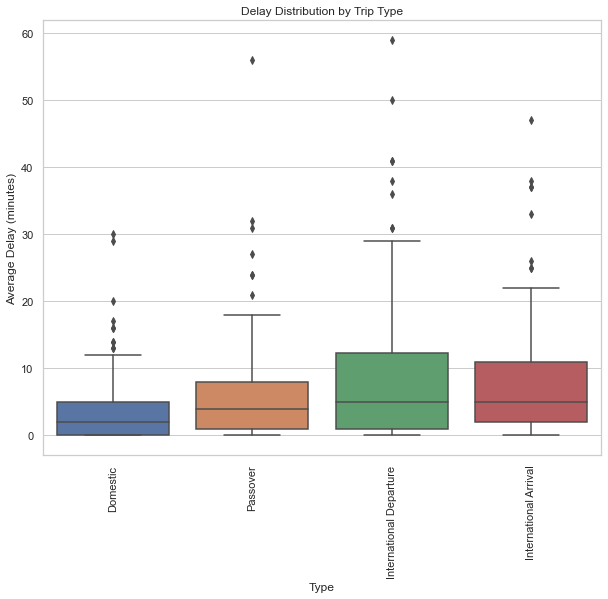

In [250]:
# Boxplot
plt.figure(figsize=(10, 8))
sns.boxplot(x='Type', y='Average Delay (minutes)', 
            data=df_tripz_no_na) # Remove Outliers
plt.xticks(rotation=90) 
plt.title("Delay Distribution by Trip Type")
plt.show()

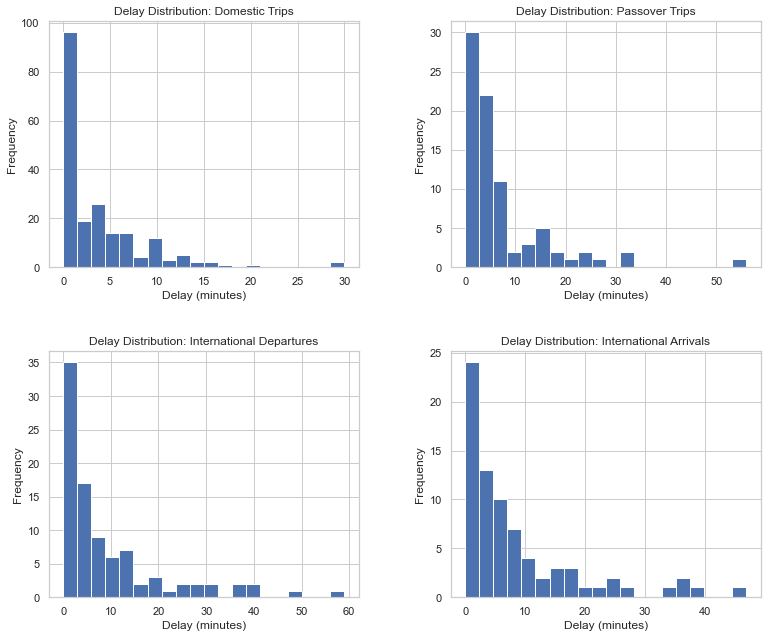

In [251]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid layout
fig.tight_layout(pad=5.0)

# Delay distributions
axes[0, 0].hist(df_tripz_no_na[df_tripz_no_na['Type'] == 'Domestic']['Average Delay (minutes)'].dropna(), bins=20)
axes[0, 0].set_title('Delay Distribution: Domestic Trips')
axes[0, 0].set_xlabel('Delay (minutes)')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(df_tripz_no_na[df_tripz_no_na['Type'] == 'Passover']['Average Delay (minutes)'].dropna(), bins=20)
axes[0, 1].set_title('Delay Distribution: Passover Trips')
axes[0, 1].set_xlabel('Delay (minutes)')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(df_tripz_no_na[df_tripz_no_na['Type'] == 'International Departure']['Average Delay (minutes)'].dropna(), bins=20)
axes[1, 0].set_title('Delay Distribution: International Departures')
axes[1, 0].set_xlabel('Delay (minutes)')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(df_tripz_no_na[df_tripz_no_na['Type'] == 'International Arrival']['Average Delay (minutes)'].dropna(), bins=20)
axes[1, 1].set_title('Delay Distribution: International Arrivals')
axes[1, 1].set_xlabel('Delay (minutes)')
axes[1, 1].set_ylabel('Frequency')

plt.show()

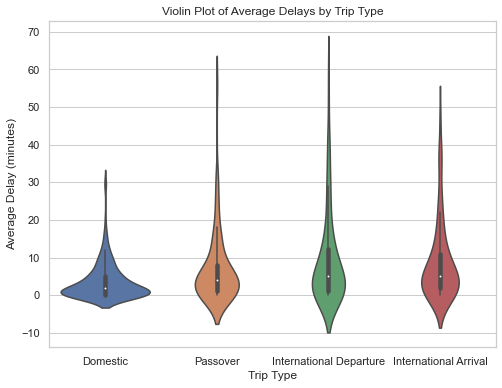

In [252]:
plt.figure(figsize=(8,6))
sns.violinplot(x='Type', y='Average Delay (minutes)', data=df_tripz_no_na)
plt.title('Violin Plot of Average Delays by Trip Type')
plt.xlabel('Trip Type')
plt.ylabel('Average Delay (minutes)')
plt.show()

---

# GTFS Data

### 2024

In [ ]:
# Load data

df_trips = pd.read_csv('./data/gtfs_2024/trips.txt') # Trips
df_routes = pd.read_csv('./data/gtfs_2024/routes.txt') # Routes
df_stop_times = pd.read_csv('./data/gtfs_2024/stop_times.txt') # Stop Times
df_stops = pd.read_csv('./data/gtfs_2024/stops.txt') # Stops

In [ ]:
# Trips

df_trip_all = df_trips.merge(df_routes, on="route_id")[["trip_id", "trip_headsign", "trip_short_name", "direction_id", 
                                                   "agency_id", "route_id",  "route_short_name", "route_type"]]

df_trip_all=df_trip_all[df_trip_all.route_type==2].drop("route_type", axis=1) # Filter buses out
df_trip_all

In [ ]:
# Stops

df_stop_all = df_stop_times[["trip_id", "stop_id", "stop_sequence"]].merge(df_stops[["stop_id", "stop_name",
                                                                      "stop_lat", "stop_lon"]], on = "stop_id")

df_stop_all

In [ ]:
# Join

df_stop_trip = df_stop_all.merge(df_trip_all, on="trip_id")
df_stop_trip

`direction_id` = 0 into Austria
`direction_id` = 1 out of Austria ... ?

In [ ]:
foreign_trips =list(set(df_stop_trip[~df_stop_trip.stop_id.str.contains("at")].trip_id)) # Trips that contain stops outside of Austria

df_trip_abroad = df_stop_trip[df_stop_trip.trip_id.isin(foreign_trips)]
df_trip_abroad[df_trip_abroad.trip_id=="145.TA.1-S1-V-j24-1.55.H"].sort_values(by="stop_sequence")

In [ ]:
grouped = df_trip_abroad.groupby('trip_id')

# Create a new dataframe with the aggregated columns
aggregated_data = []

for trip_id, group in grouped:
    # Sort the group by stop_sequence
    group = group.sort_values(by='stop_sequence')
    
    # Get the first and last stop_id and stop_name
    first_stop_id = group.iloc[0]['stop_id']
    last_stop_id = group.iloc[-1]['stop_id']
    first_stop_name = group.iloc[0]['stop_name']
    last_stop_name = group.iloc[-1]['stop_name']
    
    # Take other columns (like route_id, trip_headsign) from the first row
    other_columns = group.iloc[0].to_dict()
    
    # Remove unnecessary stop_id and stop_name from other_columns
    other_columns.pop('stop_id', None)
    other_columns.pop('stop_name', None)
    other_columns.pop('stop_sequence', None)  # Remove stop_sequence if not needed
    
    # Add the aggregated data to the list
    aggregated_data.append({
        'trip_id': trip_id,
        'first_stop_id': first_stop_id,
        'last_stop_id': last_stop_id,
        'first_stop_name': first_stop_name,
        'last_stop_name': last_stop_name,
        **other_columns  # Add other columns
    })

# Convert the aggregated data to a new dataframe
df_aggregated = pd.DataFrame(aggregated_data)

# Remove passover trains
df_aggregated=df_aggregated[~(~(df_aggregated.first_stop_id.str.contains("at")) & ~(df_aggregated.last_stop_id.str.contains("at")))]

df_aggregated

## GTFS 2023

In [ ]:
df_trips_23 = pd.read_csv('./data/gtfs_2023/trips.txt') # Trips
df_routes_23 = pd.read_csv('./data/gtfs_2023/routes.txt') # Routes
df_stop_times_23 = pd.read_csv('./data/gtfs_2023/stop_times.txt') # Stop Times
df_stops_23 = pd.read_csv('./data/gtfs_2023/stops.txt') # Stops

In [ ]:
df_trip_all_23 = df_trips_23.merge(df_routes_23, on="route_id")[["trip_id", "trip_headsign", "trip_short_name", "direction_id", 
                                                   "agency_id", "route_id",  "route_short_name", "route_type"]]

df_trip_all_23=df_trip_all_23[df_trip_all_23.route_type==2].drop("route_type", axis=1) # Filter buses out

df_stop_all_23 = df_stop_times_23[["trip_id", 
                                   "stop_id", "stop_sequence"]].merge(df_stops_23[["stop_id", "stop_name",
                                                                      "stop_lat", "stop_lon"]], on = "stop_id")

df_stop_trip_23 = df_stop_all_23.merge(df_trip_all_23, on="trip_id")

df_trip_abroad_23 = df_stop_trip_23[df_stop_trip_23.trip_id.isin(list(set(df_stop_trip_23[~df_stop_trip_23.stop_id.str.contains("at")].trip_id)))]

df_trip_abroad_23

In [ ]:
df_trip_abroad[(df_trip_abroad.trip_id=="67.TA.1-S1-V-j24-1.26.R")].sort_values(by="stop_sequence")

In [ ]:
df_sh = pd.read_csv("./data/trips_cross_border_trains_oebb.csv")
df_sh